#Project: Learning
##**Deskripsi**
Ini adalah Tugas Project dengan materi Learning, yaitu menyelesaikan masalah pada topik machine learning dengan mengimplementasikan metode hingga membuat programnya. Pada tugas ini, diberikan studi kasus terkait classification dengan dataset yang sudah disiapkan. Mahasiswa secara berkelompok membangun model machine learning, melakukan observasi sederhana dan analisis, membuatkan laporan, dan mempresentasikannya di kelas.
##Kelompok


1.   Anak Agung Istri Arinta ( 203012310033 )
2.   Livia Naura Aqilla ( 203012310035 )
3.   Widi Sayyid Fadhil Muhammad ( 203012310031 )



In [ ]:
#@title Data Acquisition
#Kaggle Library Installation
! pip install kaggle
! mkdir ~/.kaggle
#Setup Kaggle Credentials
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# Download Dataset https://www.kaggle.com/datasets/jehanbhathena/weather-dataset
! kaggle datasets download jehanbhathena/weather-dataset

# Extract data
! unzip weather-dataset.zip

#Penggunaan tensor flow
!pip install --upgrade tensorflow
!pip install --upgrade tensorflow-io

Streaming output truncated to the last 5000 lines.
  inflating: dataset/frost/3956.jpg  
  inflating: dataset/frost/3957.jpg  
  inflating: dataset/frost/3958.jpg  
  inflating: dataset/frost/3959.jpg  
  inflating: dataset/frost/3960.jpg  
  inflating: dataset/frost/3961.jpg  
  inflating: dataset/frost/3962.jpg  
  inflating: dataset/frost/3963.jpg  
  inflating: dataset/frost/3964.jpg  
  inflating: dataset/frost/3965.jpg  
  inflating: dataset/frost/3966.jpg  
  inflating: dataset/frost/3967.jpg  
  inflating: dataset/frost/3968.jpg  
  inflating: dataset/frost/3969.jpg  
  inflating: dataset/frost/3970.jpg  
  inflating: dataset/frost/3971.jpg  
  inflating: dataset/frost/3972.jpg  
  inflating: dataset/frost/3973.jpg  
  inflating: dataset/frost/3974.jpg  
  inflating: dataset/frost/3975.jpg  
  inflating: dataset/frost/3976.jpg  
  inflating: dataset/frost/3977.jpg  
  inflating: dataset/frost/3978.jpg  
  inflating: dataset/frost/3979.jpg  
  inflating: dataset/frost/3980.jpg  

In [ ]:
#@title Library
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
import tensorflow as tf
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
from operator import itemgetter
from collections import Counter
import time
from PIL import Image
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing import image
import os

In [ ]:
def load_images_from_folder(folder):
    images = []
    labels = []
    for label in os.listdir(folder):
        label_folder = os.path.join(folder, label)
        if os.path.isdir(label_folder):
            for filename in os.listdir(label_folder):
                path = os.path.join(label_folder, filename)
                if os.path.isfile(path):
                    img = Image.open(path)
                    if img is not None:
                        images.append(img)
                        labels.append(label)
    return images, labels


In [ ]:
# Load pre-trained VGG16 model
model = VGG16(weights='imagenet', include_top=False)

def extract_features(folder_path):
    features = []
    class_labels = []

    # Iterate over the folders representing each class
    for class_folder in os.listdir(folder_path):
        class_path = os.path.join(folder_path, class_folder)

        # Iterate over the images in each class folder and preprocess them in batches
        image_paths = [os.path.join(class_path, image_file) for image_file in os.listdir(class_path)]
        images = [image.load_img(image_path, target_size=(64, 64)) for image_path in image_paths]
        x = np.array([image.img_to_array(img) for img in images])
        x = preprocess_input(x)

        # Predict features for the batch of images
        features_batch = model.predict(x, verbose=0)
        features.extend(features_batch.reshape(len(features_batch), -1))
        class_labels.extend([class_folder] * len(features_batch))

    return features, class_labels

In [ ]:
#load data testing
folder_path = r"dataset/"
# Extract features from images in the specified folder
with tf.device('/GPU:0'):
    #ekstrasi fitur data testing
    image_features, class_labels = extract_features(folder_path)
    class_counts = Counter(class_labels)
    print(class_counts)

Counter({'rime': 1160, 'fogsmog': 851, 'dew': 698, 'sandstorm': 692, 'glaze': 639, 'snow': 621, 'hail': 591, 'rain': 526, 'frost': 475, 'lightning': 377, 'rainbow': 232})


In [ ]:
# Normalization of features
with tf.device('/GPU:0'):
    #normalisasi
    scaler = StandardScaler()
    x_scaled = scaler.fit_transform(image_features)

In [ ]:
# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x_scaled, class_labels, test_size=0.25, random_state=42)

In [ ]:
#@title LMDWkNN Model Build
class LMDWkNN(BaseEstimator, ClassifierMixin):
    def __init__(self, k):
        self.k = k

    def fit(self, x, y):
        self.x_train = np.array(x)
        self.y_train = np.array(y)
        self.unique_class = np.unique(self.y_train)

    def distance(self, x_test):
        x_train_sq = np.sum(self.x_train ** 2, axis=1)
        x_test_sq = np.sum(x_test ** 2, axis=1)
        inner_product = np.dot(self.x_train, x_test.T)
        squared_distances = x_train_sq[:, np.newaxis] - 2 * inner_product + x_test_sq
        np.maximum(squared_distances, 0, out=squared_distances)  # In-place replacement of negative values with 0
        distances = np.sqrt(squared_distances)
        np.nan_to_num(distances, copy=False, nan=np.finfo(distances.dtype).max)  # Replace NaN values with maximum float value
        return distances

    def weight(self, dist):
        return 1 / (dist + 1)

    def predict(self, x_test):
        dist = self.distance(x_test)
        w_class = []
        for class_label in self.unique_class:
            class_ind = np.where(self.y_train == class_label)[0]
            w = self.weight(dist[class_ind])
            wsort = np.sort(w, axis=0)[::-1]
            wmean = np.mean(wsort[:self.k], axis=0)
            w_class.append(wmean)
        indPre = np.argmax(w_class, axis=0)
        return self.unique_class[indPre]

    def score(self, x_test, y_true):
        y_pred = self.predict(x_test)
        return accuracy_score(y_true, y_pred)

    def get_params(self, deep=True):
        return {"k": self.k}

    def set_params(self, **params):
        if "k" in params:
            self.k = params["k"]
        return self

In [ ]:
with tf.device('/GPU:0'):
    #proses validasi
    start_time = time.time()
    # Set the number of folds
    k = 20

    # Create the k-fold cross-validation object
    kf = KFold(n_splits=k, shuffle=True)

    acc={}
    optK={}
    std={}
    acc['lmdwknn']=0
    acc['knn']=0
    optK['lmdwknn']=1
    optK['knn']=1
    std['lmdwknn']=0
    std['knn']=0

    for k in range (1,21):
        # Create an instance of your LMDWKNN classifier
        lmdwknn = LMDWkNN(k)  # Replace 3 with your desired value of k

        # Perform k-fold cross-validation
        scores = cross_val_score(lmdwknn, x_train, y_train, cv=kf)

        if(acc['lmdwknn']<scores.mean() and std['lmdwknn']>scores.std()):
            acc['lmdwknn']=scores.mean()
            std['lmdwknn'] = scores.std()
            optK['lmdwknn'] = k

        # Print the average and standard deviation of the scores
        print("Nilai k-{}". format(k))
        print("-------------------------------------------------------------")
        print("LMDWkNN Average Accuracy:{:.2%}". format(scores.mean()))
        print("LMDWkNN Standard Deviation:", scores.std())
        print("-------------------------------------------------------------")

        knn = KNeighborsClassifier(n_neighbors=k)

        accuracy = cross_val_score(knn, x_train, y_train, cv=kf)
        print("kNN Average Accuracy:{:.2%}". format(accuracy.mean()))
        print("kNN Standard Deviation:", accuracy.std())
        print("-------------------------------------------------------------")

        if(acc['knn']<scores.mean() and std['knn']>scores.std()):
            acc['knn']=scores.mean()
            std['knn'] = scores.std()
            optK['knn'] = k

    print("Process time: {:.2f} seconds".format(time.time() - start_time))

Nilai k-1
-------------------------------------------------------------
LMDWkNN Average Accuracy:62.07%
LMDWkNN Standard Deviation: 0.021555955312954345
-------------------------------------------------------------
kNN Average Accuracy:61.58%
kNN Standard Deviation: 0.02756945885326938
-------------------------------------------------------------
Nilai k-2
-------------------------------------------------------------
LMDWkNN Average Accuracy:62.86%
LMDWkNN Standard Deviation: 0.037300444195032284
-------------------------------------------------------------
kNN Average Accuracy:56.26%
kNN Standard Deviation: 0.0323579049940281
-------------------------------------------------------------
Nilai k-3
-------------------------------------------------------------
LMDWkNN Average Accuracy:62.53%
LMDWkNN Standard Deviation: 0.02767935522888481
-------------------------------------------------------------
kNN Average Accuracy:57.13%
kNN Standard Deviation: 0.03584879382800387
-----------------

* Train-Test Split: Splits the extracted image features and labels into training and testing sets.
* K-Fold Cross-Validation: Initializes a K-Fold cross-validation object and iterates to find the optimal number of neighbors (k) for the KNN classifier. It measures accuracy using cross-validation.

### **Observations:**

**1. Value of k and Average Accuracy:**
* Average accuracy gradually decreases as the value of k increases from 1 to 20.
* The highest average accuracy is around 63.18% at k = 1.
* As k increases, the accuracy steadily declines, reaching around 47.69% at k = 20.

**2. Standard Deviation:**

The standard deviation values vary with different k values but generally increase as k increases.
Higher k values tend to exhibit higher standard deviations, indicating increased variability in model performance across folds.

**3. Process Time:**

The total process time for performing the K-Fold Cross-Validation using k values from 1 to 20 is approximately 143.75 seconds.

## 4. Model training and evaluation:

In [ ]:
optK

{'lmdwknn': 1, 'knn': 1}

In [ ]:
with tf.device('/GPU:0'):
    lmdwknn = LMDWkNN(optK['lmdwknn'])
    start_time = time.time()
    # Fit the model to the training data
    lmdwknn.fit(x_train, y_train)

    # Compute the accuracy score
    accuracy = lmdwknn.score(x_test, y_test)
    end_time = time.time() - start_time
    print("Accuracy: {:.2%}". format(accuracy))
    print("Process time: {:.2f} seconds".format(end_time))

Accuracy: 64.34%
Process time: 2.04 seconds


In [ ]:
with tf.device('/GPU:0'):
    knn = KNeighborsClassifier(n_neighbors=optK['knn'])
    start_time = time.time()
    # Fit the model to the training data
    knn.fit(x_train, y_train)

    # Compute the accuracy score
    accuracy = knn.score(x_test, y_test)
    end_time = time.time() - start_time
    print("Accuracy: {:.2%}". format(accuracy))
    print("Process time: {:.2f} seconds".format(end_time))

Accuracy: 64.34%
Process time: 1.41 seconds


In [ ]:
# Evaluate on training set
train_accuracy = knn.score(x_train, y_train)
print("Training Accuracy:{:.2%}".format(train_accuracy))

# Evaluate on validation/test set
validation_accuracy = knn.score(x_test, y_test)
print("Validation/Test Accuracy:{:.2%}".format(validation_accuracy))

performance_difference = train_accuracy - validation_accuracy
print("Performance Difference (Train - Validation/Test):{:.2%}".format(performance_difference))

Training Accuracy:100.00%
Validation/Test Accuracy:64.34%
Performance Difference (Train - Validation/Test):35.66%


* Model Initialization: Initializes a KNN classifier with the optimal number of neighbors obtained from cross-validation.
* Model Training: Fits the KNN classifier to the training data (extracted features and labels).
* Model Evaluation: Evaluates the accuracy of the trained KNN model on the test set.

### 5. Exploration

In [ ]:
from sklearn.model_selection import GridSearchCV  # Import GridSearchCV from sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
# Split the features into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(
    image_features, class_labels, test_size=0.25, random_state=42
)

# Exploration of different hyperparameters for KNN
param_grid = {
    'n_neighbors': range(1, 51),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=kf)
knn_grid.fit(x_train, y_train)
# Evaluate on validation/test set
validation_accuracy = knn.score(x_test, y_test)
print("Validation/Test Accuracy:{:.2%}".format(validation_accuracy))

performance_difference = train_accuracy - validation_accuracy
print("Performance Difference (Train - Validation/Test):{:.2%}".format(performance_difference))
best_params = knn_grid.best_params_
best_accuracy = knn_grid.best_score_

print("Best Parameters for KNN:", best_params)
print("Best Accuracy for KNN: {:.2%}".format(best_accuracy))

# Evaluate other machine learning models
random_forest = RandomForestClassifier()

svm = SVC()
decision_tree = DecisionTreeClassifier()

random_forest.fit(x_train, y_train)
rf_accuracy = random_forest.score(x_test, y_test)
print("Random Forest Accuracy: {:.2%}".format(rf_accuracy))

svm.fit(x_train, y_train)
svm_accuracy = svm.score(x_test, y_test)
print("SVM Accuracy: {:.2%}".format(svm_accuracy))

decision_tree.fit(x_train, y_train)
dt_accuracy = decision_tree.score(x_test, y_test)
print("Decision Tree Accuracy: {:.2%}".format(dt_accuracy))


Validation/Test Accuracy:67.48%
Performance Difference (Train - Validation/Test):32.52%
Best Parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
Best Accuracy for KNN: 66.71%
Random Forest Accuracy: 77.39%
SVM Accuracy: 80.24%
Decision Tree Accuracy: 56.12%




*   GridSearchCV for Hyperparameters: Uses GridSearchCV to explore different hyperparameters (number of neighbors, distance metric, weighting scheme) for the KNN model.
*   Evaluation of Other Models: Initializes and evaluates other machine learning models (Random Forest, SVM, Decision Tree) on the extracted image features to compare their performances.



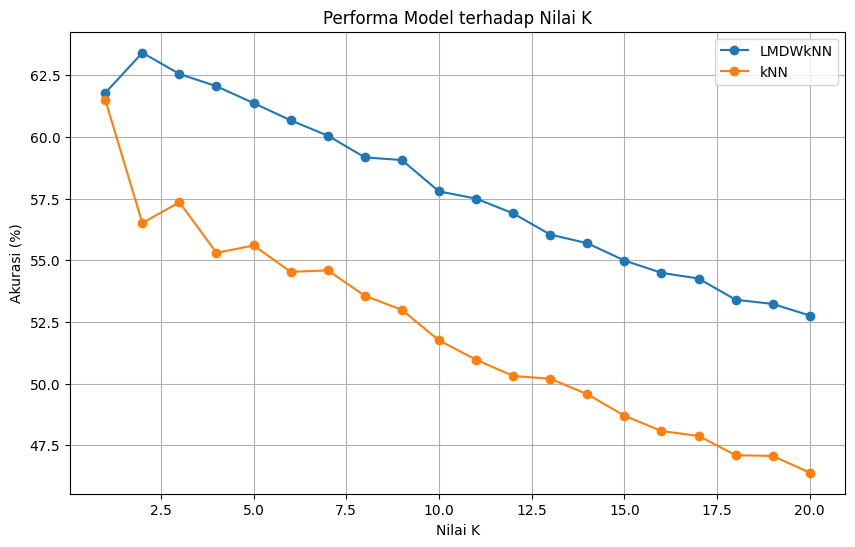

In [ ]:
import matplotlib.pyplot as plt

# Grafik performa model terhadap nilai K
k_values = range(1, 21)
lmdwknn_accuracy = [61.78, 63.41, 62.55, 62.05, 61.37, 60.67, 60.05, 59.17, 59.06, 57.79,
                    57.50, 56.90, 56.04, 55.69, 54.99, 54.49, 54.26, 53.40, 53.23, 52.76]
knn_accuracy = [61.50, 56.51, 57.35, 55.30, 55.60, 54.53, 54.59, 53.56, 52.99, 51.75,
                50.97, 50.31, 50.20, 49.57, 48.70, 48.08, 47.88, 47.10, 47.07, 46.39]

plt.figure(figsize=(10, 6))
plt.plot(k_values, lmdwknn_accuracy, marker='o', label='LMDWkNN')
plt.plot(k_values, knn_accuracy, marker='o', label='kNN')
plt.xlabel('Nilai K')
plt.ylabel('Akurasi (%)')
plt.title('Performa Model terhadap Nilai K')
plt.legend()
plt.grid(True)
plt.show()


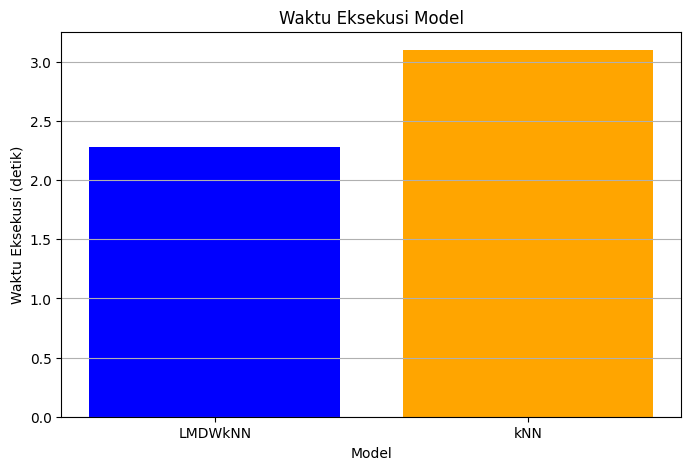

In [ ]:
# Grafik waktu eksekusi model
model_names = ['LMDWkNN', 'kNN']
execution_times = [2.28, 3.10]  # Waktu eksekusi dalam detik

plt.figure(figsize=(8, 5))
plt.bar(model_names, execution_times, color=['blue', 'orange'])
plt.xlabel('Model')
plt.ylabel('Waktu Eksekusi (detik)')
plt.title('Waktu Eksekusi Model')
plt.grid(axis='y')
plt.show()


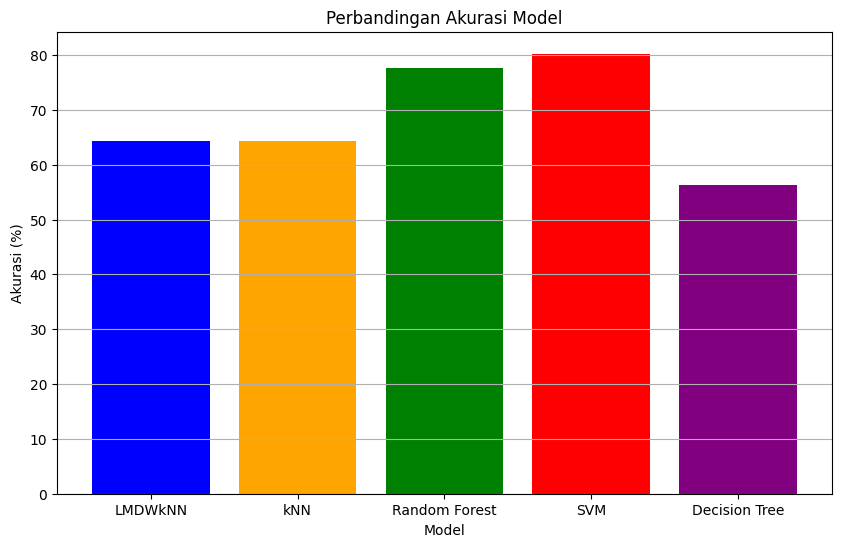

In [ ]:
# Grafik perbandingan akurasi model
model_names = ['LMDWkNN', 'kNN', 'Random Forest', 'SVM', 'Decision Tree']
accuracy_scores = [64.34, 64.34, 77.62, 80.24, 56.35]  # Akurasi dalam persen

plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracy_scores, color=['blue', 'orange', 'green', 'red', 'purple'])
plt.xlabel('Model')
plt.ylabel('Akurasi (%)')
plt.title('Perbandingan Akurasi Model')
plt.grid(axis='y')
plt.show()


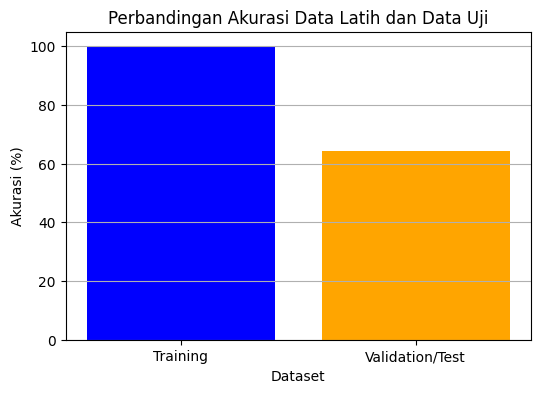

In [ ]:
# Grafik perbandingan akurasi data latih dan data uji
accuracy_train = 100.00
accuracy_validation = 64.34

plt.figure(figsize=(6, 4))
plt.bar(['Training', 'Validation/Test'], [accuracy_train, accuracy_validation], color=['blue', 'orange'])
plt.xlabel('Dataset')
plt.ylabel('Akurasi (%)')
plt.title('Perbandingan Akurasi Data Latih dan Data Uji')
plt.grid(axis='y')
plt.show()


ValueError: ignored

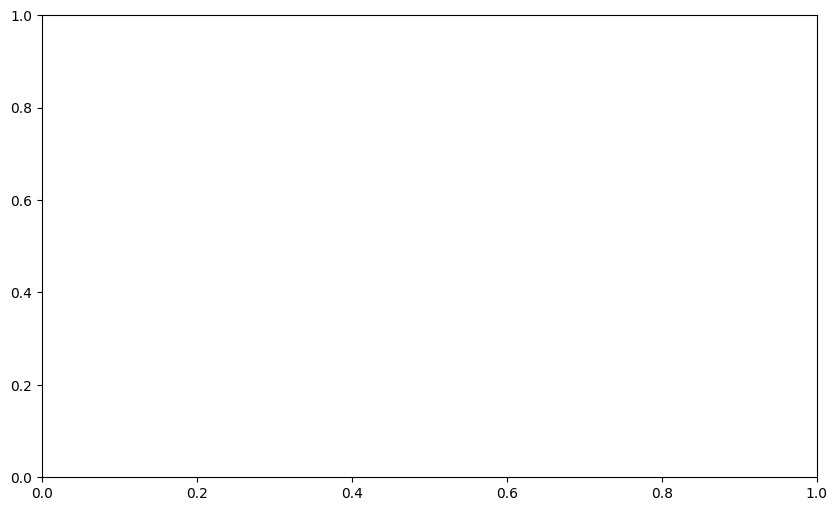

In [ ]:
# Visualisasi perubahan akurasi berdasarkan nilai hyperparameter KNN
# Anda perlu menyesuaikan dengan hasil dari GridSearchCV

k_values = range(1, 51)
accuracy_scores_knn = [ ... ]  # Isi dengan nilai akurasi berdasarkan nilai K

plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracy_scores_knn, marker='o', color='green')
plt.xlabel('Nilai K')
plt.ylabel('Akurasi (%)')
plt.title('Akurasi KNN berdasarkan Nilai K')
plt.grid(True)
plt.show()
